# Monopoly Statistical Analysis

by Eric Bennett

In this analyis I will be taking a look at the probabilities of landing on each specific space in Monopoly, and with that a cost-benefit analysis of the different property chains in Monopoly. This may seem simple in theory with fair dice, but Monopoly has several ways of shifting the players location around the board, including the Go to Jail tile, the potential of teleportation with Chance and Community Chest cards, the impacts of jail on rolling different amounts, etc.

To begin to answer this question I have created a simple simulation of a Monopoly game with a single player circling the board in N rolls, accounting for jail rules (three tries)

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

## Board Probabilities
Here I will create some simple graphs to show the comparative probabilities of each space on the board with a single player taking 100,000,000 turns on the board

In [76]:
# Add a column for the Probablilities of each Space
df = pd.read_csv("monopoly.csv")
total_turns = df['Frequency'].sum()

df['Probability'] = df['Frequency'].apply(lambda x: (x / total_turns))
df.head()

,Space,Frequency,30_turns_4_players,30turns_4players,Probability
0,GO,3680058,42277,4200084,0.030828
1,Mediterranean Avenue,2549386,28298,2829381,0.021356
2,Community Chest 1,2247349,25865,2583946,0.018826
3,Baltic Avenue,2585575,30603,3074121,0.021659
4,Income Tax,2777111,34584,3437279,0.023264


First, a chart showing the order of the game:

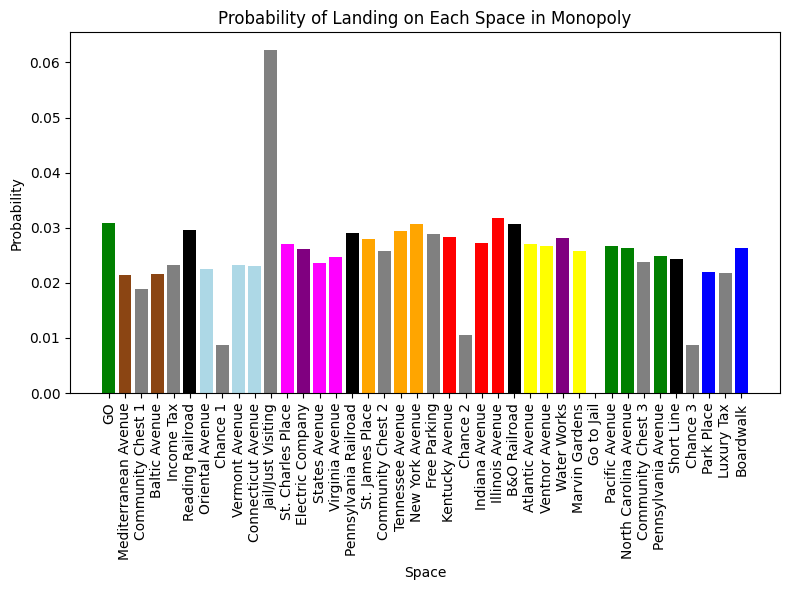

In [77]:
# color mapping
color_mapping = {
    'GO': 'green',  # Red
    'Mediterranean Avenue': '#8B4513',  # Brown
    'Community Chest 1': 'grey',  # White
    'Baltic Avenue': '#8B4513',  # Brown
    'Income Tax': 'grey', 
    'Reading Railroad': '#000000',  # Black
    'Oriental Avenue': '#ADD8E6',  # Light Blue
    'Chance 1': 'grey', 
    'Vermont Avenue': '#ADD8E6',  # Light Blue
    'Connecticut Avenue': '#ADD8E6',  # Light Blue
    'Jail/Just Visiting': 'grey',
    'St. Charles Place': '#FF00FF',  # Magenta
    'Electric Company': 'purple',
    'States Avenue': '#FF00FF',  # Magenta
    'Virginia Avenue': '#FF00FF',  # Magenta
    'Pennsylvania Railroad': '#000000',  # Black
    'St. James Place': '#FFA500',  # Orange
    'Community Chest 2': 'grey', 
    'Tennessee Avenue': '#FFA500',  # Orange
    'New York Avenue': '#FFA500',  # Orange
    'Free Parking': 'grey',
    'Kentucky Avenue': '#FF0000',  # Red
    'Chance 2': 'grey', 
    'Indiana Avenue': '#FF0000',  # Red
    'Illinois Avenue': '#FF0000',  # Red
    'B&O Railroad': '#000000',  # Black
    'Atlantic Avenue': '#FFFF00',  # Yellow
    'Ventnor Avenue': '#FFFF00',  # Yellow
    'Water Works': 'purple',
    'Marvin Gardens': '#FFFF00',  # Yellow
    'Go to Jail': 'grey', 
    'Pacific Avenue': '#008000',  # Green
    'North Carolina Avenue': '#008000',  # Green
    'Community Chest 3': 'grey', 
    'Pennsylvania Avenue': '#008000',  # Green
    'Short Line': '#000000',  # Black
    'Chance 3': 'grey', 
    'Park Place': '#0000FF',  # Dark Blue
    'Luxury Tax': 'grey', 
    'Boardwalk': '#0000FF'  # Dark Blue
}

bar_colors = df['Space'].map(color_mapping)


plt.figure(figsize=(8, 6))
plt.bar(df['Space'], df['Probability'], color=bar_colors)
plt.xticks(rotation=90)  # Rotate the space names for better readability
plt.xlabel('Space')
plt.ylabel('Probability')
plt.title('Probability of Landing on Each Space in Monopoly')
plt.tight_layout()
plt.show()

Note the extremely low probabilities of the Chance tiles and Go to Jail. This isn't because they weren't landed on, but because rather than counting each square you land on I counted each square you END YOUR TURN on. Go to Jail becomes 0 because you can't end a turn at that square, you are teleported to Jail. Similarly, 10/16 of the Chance cards teleport you to some other square, lowering the probabilities of ending a turn on one of the Chance cards significantly. Next I will create a graph showing the order of probabilities from highest to lowest:

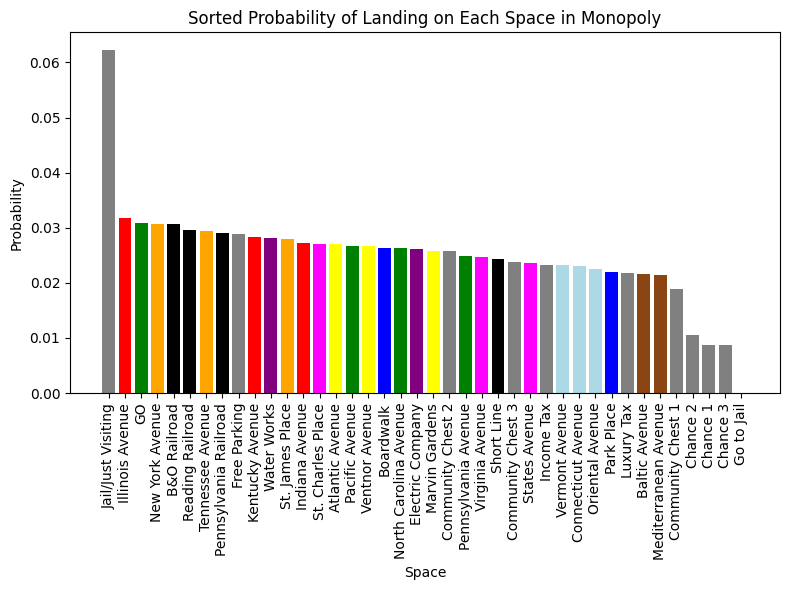

Highest probability spaces to land on:


,Space,Frequency,30_turns_4_players,30turns_4players,Probability
10,Jail/Just Visiting,7442668,90700,9048993,0.062347
24,Illinois Avenue,3799502,45321,4539299,0.031828
0,GO,3680058,42277,4200084,0.030828
19,New York Avenue,3668330,44248,4441340,0.030729
25,B&O Railroad,3660173,43669,4337323,0.030661
5,Reading Railroad,3542331,43731,4422132,0.029674


In [78]:
#create a sorted df
df_sorted = df.sort_values(by='Probability', ascending=False)

bar_colors = df_sorted['Space'].map(color_mapping)

#plot
plt.figure(figsize=(8, 6))
plt.bar(df_sorted['Space'], df_sorted['Probability'], color=bar_colors)
plt.xticks(rotation=90)  # Rotate the space names for better readability
plt.xlabel('Space')
plt.ylabel('Probability')
plt.title('Sorted Probability of Landing on Each Space in Monopoly')
plt.tight_layout()
plt.show()

print("Highest probability spaces to land on:")
df_sorted.head(6)

## Board Probabilities 2: Slightly More Realistic

For this section I will be doing much of the same as above except using a more "accurate" simulation of the game. Instead of continuing around with one player 100,000,000 times, I will record data from 4 individual players each playing 30 turns a game over 10,000 games.

In [79]:
# Add a column for the Probablilities of each Space
df_2 = pd.read_csv("monopoly.csv")
total_turns_2 = df_2['30turns_4players'].sum()

df_2['Probability_30turns_4players'] = df_2['30turns_4players'].apply(lambda x: (x / total_turns_2))
df_2.head()

,Space,Frequency,30_turns_4_players,30turns_4players,Probability_30turns_4players
0,GO,3680058,42277,4200084,0.029324
1,Mediterranean Avenue,2549386,28298,2829381,0.019754
2,Community Chest 1,2247349,25865,2583946,0.018041
3,Baltic Avenue,2585575,30603,3074121,0.021463
4,Income Tax,2777111,34584,3437279,0.023999


First, a chart showing the order of the game:

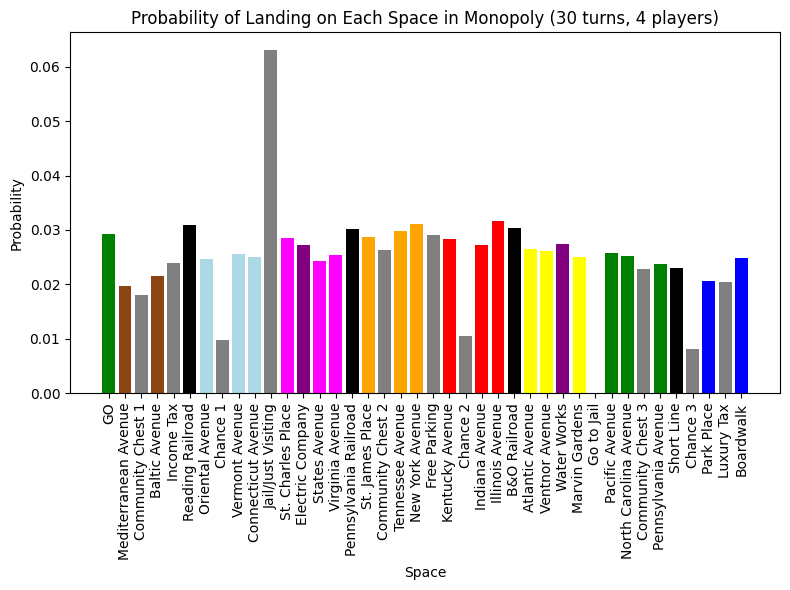

In [80]:
# color mapping
color_mapping = {
    'GO': 'green',  # Red
    'Mediterranean Avenue': '#8B4513',  # Brown
    'Community Chest 1': 'grey',  # White
    'Baltic Avenue': '#8B4513',  # Brown
    'Income Tax': 'grey', 
    'Reading Railroad': '#000000',  # Black
    'Oriental Avenue': '#ADD8E6',  # Light Blue
    'Chance 1': 'grey', 
    'Vermont Avenue': '#ADD8E6',  # Light Blue
    'Connecticut Avenue': '#ADD8E6',  # Light Blue
    'Jail/Just Visiting': 'grey',
    'St. Charles Place': '#FF00FF',  # Magenta
    'Electric Company': 'purple',
    'States Avenue': '#FF00FF',  # Magenta
    'Virginia Avenue': '#FF00FF',  # Magenta
    'Pennsylvania Railroad': '#000000',  # Black
    'St. James Place': '#FFA500',  # Orange
    'Community Chest 2': 'grey', 
    'Tennessee Avenue': '#FFA500',  # Orange
    'New York Avenue': '#FFA500',  # Orange
    'Free Parking': 'grey',
    'Kentucky Avenue': '#FF0000',  # Red
    'Chance 2': 'grey', 
    'Indiana Avenue': '#FF0000',  # Red
    'Illinois Avenue': '#FF0000',  # Red
    'B&O Railroad': '#000000',  # Black
    'Atlantic Avenue': '#FFFF00',  # Yellow
    'Ventnor Avenue': '#FFFF00',  # Yellow
    'Water Works': 'purple',
    'Marvin Gardens': '#FFFF00',  # Yellow
    'Go to Jail': 'grey', 
    'Pacific Avenue': '#008000',  # Green
    'North Carolina Avenue': '#008000',  # Green
    'Community Chest 3': 'grey', 
    'Pennsylvania Avenue': '#008000',  # Green
    'Short Line': '#000000',  # Black
    'Chance 3': 'grey', 
    'Park Place': '#0000FF',  # Dark Blue
    'Luxury Tax': 'grey', 
    'Boardwalk': '#0000FF'  # Dark Blue
}

bar_colors = df_2['Space'].map(color_mapping)


plt.figure(figsize=(8, 6))
plt.bar(df_2['Space'], df_2['Probability_30turns_4players'], color=bar_colors)
plt.xticks(rotation=90)
plt.xlabel('Space')
plt.ylabel('Probability')
plt.title('Probability of Landing on Each Space in Monopoly (30 turns, 4 players)')
plt.tight_layout()
plt.show()

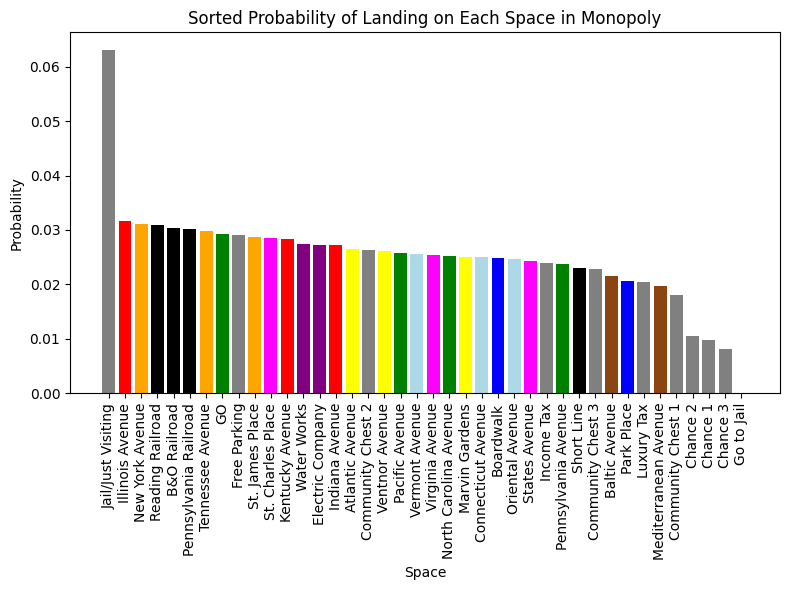

Highest probability spaces to land on:


,Space,Frequency,30_turns_4_players,30turns_4players,Probability_30turns_4players
10,Jail/Just Visiting,7442668,90700,9048993,0.063179
24,Illinois Avenue,3799502,45321,4539299,0.031693
19,New York Avenue,3668330,44248,4441340,0.031009
5,Reading Railroad,3542331,43731,4422132,0.030875
25,B&O Railroad,3660173,43669,4337323,0.030283
15,Pennsylvania Railroad,3475452,43108,4330557,0.030235


In [81]:
#create a sorted df
df_sorted_2 = df_2.sort_values(by='Probability_30turns_4players', ascending=False)

bar_colors = df_sorted_2['Space'].map(color_mapping)

#plot
plt.figure(figsize=(8, 6))
plt.bar(df_sorted_2['Space'], df_sorted_2['Probability_30turns_4players'], color=bar_colors)
plt.xticks(rotation=90)
plt.xlabel('Space')
plt.ylabel('Probability')
plt.title('Sorted Probability of Landing on Each Space in Monopoly')
plt.tight_layout()
plt.show()

print("Highest probability spaces to land on:")
df_sorted_2.head(6)

While on first glance it looks similar, there are actually a lot of shifts with this new system caused by the different format. For example:
- Pennsylvania Railroad beat out Tennessee Avenue to place 3 railroads in a row
- The spread of the magentas has increased, making them very volatile
- The light blues, originally in a row at the bottom, have climbed up in the rankinds
- the browns are slightly better, and Park Place is slightly worse

Given that the format of this simulation is more accurate to a realistic game I'll be using it as the probabilities going forward.

## Simple Price Analysis!

In this section I will be working to establish expected profit values over 'time'(some amount of rolls) for each amount of houses on each property type. To start, I've recorded each property and their probabilities in a .csv file labeled "prices.csv" (also note this uses the $100 luxury tax which was established in 2008)

In [82]:
price_df = pd.read_csv("prices.csv")

price_df.head()

,location,location_type,base_cost,cost_per_house,no_set,set,1,2,3,4,5
0,GO,Misc,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Mediterranean Avenue,Brown,-60.0,-50.0,2.0,4.0,10.0,30.0,90.0,160.0,250.0
2,Community Chest 1,Community Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Baltic Avenue,Brown,-60.0,-50.0,4.0,8.0,20.0,60.0,180.0,320.0,450.0
4,Income Tax,Fine,-200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Simple Introduction: Which base property is best

To begin to get my footing with this sort of calculation, I will be finding which single property is best assuming no property group bonuses or upgrades, adjusted for the probabilties we found above. Note that for the utilities I have found the Expected Value over all types of rolls, which is $28 when owning 1 or $70 when owning both (this loses some detail as the probabilities of landing on the utilities could be different than just a regular dice roll probability because of teleportations etc., changing this expected value, I may address this in the future)

In [83]:
base_price_df = price_df[['location', 'base_cost', 'no_set']].copy() #capture just the part of price we want
base_price_df['probability'] = df_2['Probability_30turns_4players'].copy()

new_columns = {}

for i in range(1, 1200):
    new_columns[f"{i}"] = (base_price_df['no_set'] * base_price_df['probability'] * i) + base_price_df['base_cost']
new_columns_df = pd.DataFrame(new_columns)

base_price_df = pd.concat([base_price_df, new_columns_df], axis=1)


base_price_df = base_price_df.transpose()
col_names = base_price_df.iloc[0]

base_price_df = base_price_df.drop(base_price_df.index[:4]).reset_index(drop=True)
base_price_df.columns = col_names

base_price_df.head()

location,GO,Mediterranean Avenue,Community Chest 1,Baltic Avenue,Income Tax,Reading Railroad,Oriental Avenue,Chance 1,Vermont Avenue,Connecticut Avenue,...,Go to Jail,Pacific Avenue,North Carolina Avenue,Community Chest 3,Pennsylvania Avenue,Short Line,Chance 3,Park Place,Luxury Tax,Boardwalk
0,NaN,-59.960491,NaN,-59.914148,NaN,-199.228134,-99.851831,NaN,-99.846101,-119.79999,...,NaN,-299.329468,-299.345599,NaN,-319.33406,-199.423138,NaN,-349.279438,NaN,-398.754872
1,NaN,-59.920983,NaN,-59.828296,NaN,-198.456268,-99.703663,NaN,-99.692203,-119.59998,...,NaN,-298.658936,-298.691198,NaN,-318.668121,-198.846276,NaN,-348.558876,NaN,-397.509744
2,NaN,-59.881474,NaN,-59.742444,NaN,-197.684402,-99.555494,NaN,-99.538304,-119.39997,...,NaN,-297.988404,-298.036796,NaN,-318.002181,-198.269415,NaN,-347.838314,NaN,-396.264617
3,NaN,-59.841966,NaN,-59.656591,NaN,-196.912536,-99.407326,NaN,-99.384405,-119.19996,...,NaN,-297.317872,-297.382395,NaN,-317.336241,-197.692553,NaN,-347.117752,NaN,-395.019489
4,NaN,-59.802457,NaN,-59.570739,NaN,-196.14067,-99.259157,NaN,-99.230507,-118.99995,...,NaN,-296.647339,-296.727994,NaN,-316.670301,-197.115691,NaN,-346.397191,NaN,-393.774361


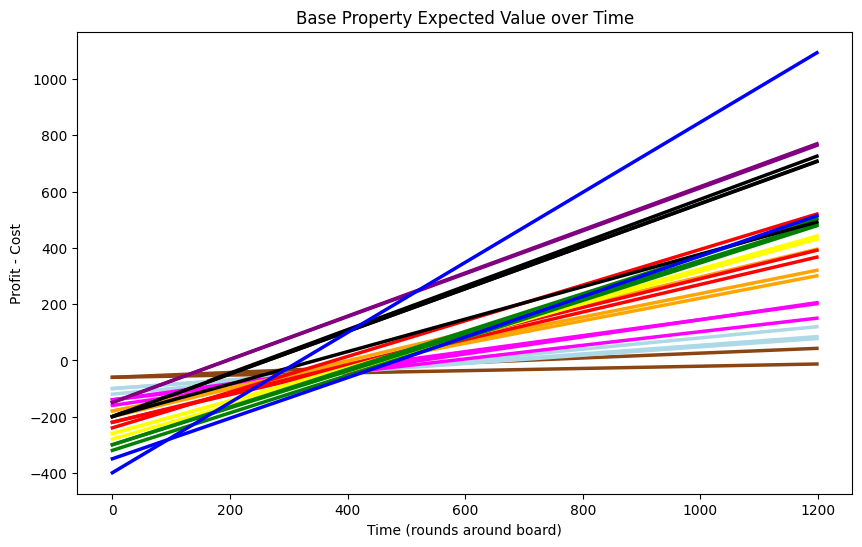

In [84]:
plt.figure(figsize=(10, 6))

for column in base_price_df.columns:
    plt.plot(base_price_df.index, base_price_df[column], label=column, color=color_mapping.get(column, '#000000'), linewidth=2.5)

plt.xlabel('Time (rounds around board)')
plt.ylabel('Profit - Cost')
plt.title('Base Property Expected Value over Time')
# plt.legend(title="Columns")
plt.show()

In [85]:
#print order of success at N = 1000
check_df = base_price_df.transpose()

check_df[1000] = check_df[1000].astype(float)
check_df_sorted = check_df.sort_values(by=1000, ascending=False)

counter = 0
for val in check_df_sorted.index.values:
    counter += 1
    if counter <= 15:
        print(f"{counter}. {val}")

1. Boardwalk
2. Water Works
3. Electric Company
4. Reading Railroad
5. B&O Railroad
6. Pennsylvania Railroad
7. Illinois Avenue
8. Short Line
9. Park Place
10. Pacific Avenue
11. North Carolina Avenue
12. Pennsylvania Avenue
13. Atlantic Avenue
14. Marvin Gardens
15. Ventnor Avenue


### Average Time of a Monopoly Game

This is pretty easy as we already have the values, we just need to decide what "Time" value we assign to the average game.

To do this I'll be manipulating some data from [this website](https://blog.ed.ted.com/2017/12/01/heres-how-to-win-at-monopoly-according-to-math-experts/) to make an estimation.

In [86]:
average_roll = 7
turns_per_player = 30 #estimate

total_tiles = average_roll * turns_per_player
total_rounds = total_tiles / 40 #number of times around (our Time variable)
print(f"On average in a game with {turns_per_player} turns per player you go {total_rounds} times around the board (not counting any teleportation)!")

On average in a game with 30 turns per player you go 5.25 times around the board (not counting any teleportation)!


In [87]:
check_df = base_price_df.transpose()

check_df[5] = check_df[5].astype(float) #this is actually the 6 time around the board rounding up because I can (should help offset some of the teleportation stuff)


check_df_sorted = check_df.sort_values(by=5, ascending=False)
counter = 0
for val in check_df_sorted.index.values:
    counter += 1
    if counter <= 10:
        print(f"{counter}. {val}")

1. Baltic Avenue
2. Mediterranean Avenue
3. Vermont Avenue
4. Oriental Avenue
5. Connecticut Avenue
6. St. Charles Place
7. States Avenue
8. Water Works
9. Electric Company
10. Virginia Avenue


As you can see with this metric the cheapest properties are given a great emphasis not because they are making good returns, but because they are the LEAST negative in their returns since the properties are really cheap. We'll do a quick check to see if any properties are able to buck this trend or if it is in strict price order.

In [88]:
price_order_df = check_df[[5]].copy()
individual_price_df = price_df['base_cost'].copy()

#getting them to match up
price_order_df_reset = price_order_df.reset_index()
price_order_df_reset.columns = ['location', '5']
individual_price_df_reset = individual_price_df.reset_index(drop=True)

price_order_df = pd.concat([price_order_df_reset, individual_price_df_reset], axis=1) #combining

price_order_df_sorted = price_order_df.sort_values(by='5', ascending=False)

price_order_df_sorted.head(28) #only gets tiles which are viable


,location,5,base_cost
3,Baltic Avenue,-59.484887,-60.0
1,Mediterranean Avenue,-59.762948,-60.0
8,Vermont Avenue,-99.076608,-100.0
6,Oriental Avenue,-99.110988,-100.0
9,Connecticut Avenue,-118.799940,-120.0
11,St. Charles Place,-138.290222,-140.0
13,States Avenue,-138.548039,-140.0
28,Water Works,-145.398779,-150.0
12,Electric Company,-145.426758,-150.0
14,Virginia Avenue,-158.172408,-160.0


As you can see the properties are in fact exactly in order of their price to buy! Not very conclusive about what properties are better than others : (

### Return On Investment

Here we can adjust the above work to not measure just the cost at "Time" count 5, but the % of the base cost recouped at that time, yielding more interesting results.

In [89]:
price_order_df_copy = price_order_df.copy()

price_order_df_copy['percent_change'] = (price_order_df_copy['5'] - price_order_df_copy['base_cost']) / (-1 * price_order_df_copy['base_cost'])
price_order_df_copy_sorted = price_order_df_copy.sort_values(by='percent_change', ascending=False).reset_index(drop=True)

price_order_df_copy_sorted.head(28) 

,location,5,base_cost,percent_change
0,Water Works,-145.398779,-150.0,0.030675
1,Electric Company,-145.426758,-150.0,0.030488
2,Reading Railroad,-195.368805,-200.0,0.023156
3,B&O Railroad,-195.457623,-200.0,0.022712
4,Pennsylvania Railroad,-195.464709,-200.0,0.022676
5,Boardwalk,-392.529233,-400.0,0.018677
6,Short Line,-196.538829,-200.0,0.017306
7,Illinois Avenue,-236.196879,-240.0,0.015846
8,New York Avenue,-197.023161,-200.0,0.014884
9,Tennessee Avenue,-177.496558,-180.0,0.013908


Notable here is the massive jumps of the utilities and the railroads. While I don't find the utilities data completely binding as it is still working on always hitting the average roll of 7 which I haven't fully checked the validity of yet, it's notable that the railroads (besides Short Line) even beat out Boardwalk (both the railroads and Boardwalk have some of the highest base %return at 1/8).

This leads us to the first actionable advice from this work: If there's any property you only want to have 1 of, it should either be Boardwalk or a railroad or a utility!

## Complex Price Analysis

With that basic analysis complete we will now begin to integrate ways of making more money on a property, including having sets of properties and having houses on properties.

I considered keeping each property as an individual item for this section, but in order to get 2 hourses on a property you need to have 1 house on each as well as buying the properties in the first place. I could add those costs to the cost for the single property but that extra money isn't just deadweight, it can also be used to make more money. With that in mind I will be grouping the properties and comparing the values of each set (with variable amounts of houses) with each other.

In [90]:
complex_price_df = pd.read_csv("prices.csv")

complex_price_df.head()

,location,location_type,base_cost,cost_per_house,no_set,set,1,2,3,4,5
0,GO,Misc,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Mediterranean Avenue,Brown,-60.0,-50.0,2.0,4.0,10.0,30.0,90.0,160.0,250.0
2,Community Chest 1,Community Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Baltic Avenue,Brown,-60.0,-50.0,4.0,8.0,20.0,60.0,180.0,320.0,450.0
4,Income Tax,Fine,-200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Having Full Set

In [91]:
full_set_df = complex_price_df[['location', 'location_type', 'base_cost', 'set']].copy() #capture just the part of price we want
full_set_df['probability'] = df_2['Probability_30turns_4players'].copy()

new_columns = {} # do something here
for i in range(1, 100):
    new_columns[f"{i}"] = (full_set_df['set'] * full_set_df['probability'] * i) + full_set_df['base_cost']
new_columns_df = pd.DataFrame(new_columns)

full_set_df = pd.concat([full_set_df, new_columns_df], axis=1)


full_set_df = full_set_df.transpose()
col_names = full_set_df.iloc[0]

full_set_df = full_set_df.drop(full_set_df.index[:5]).reset_index(drop=True)
full_set_df.columns = col_names




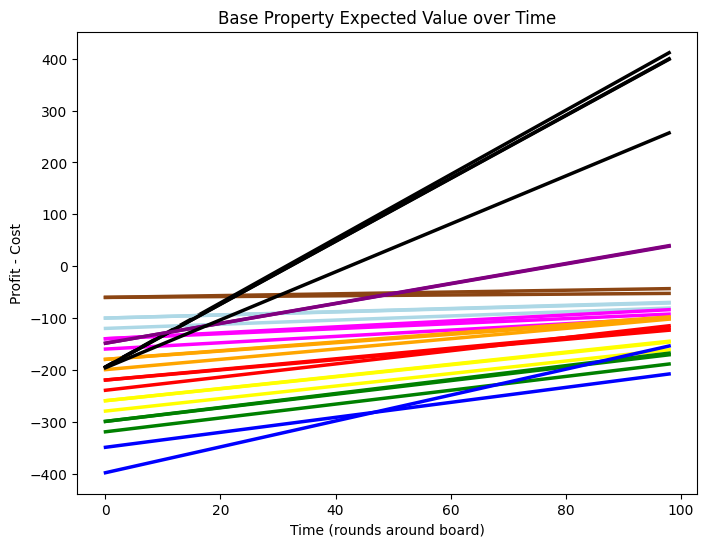

In [92]:
plt.figure(figsize=(8, 6))

for column in full_set_df.columns:
    plt.plot(full_set_df.index, full_set_df[column], label=column, color=color_mapping.get(column, '#000000'), linewidth=2.5)

plt.xlabel('Time (rounds around board)')
plt.ylabel('Profit - Cost')
plt.title('Base Property Expected Value over Time')
# plt.legend(title="Columns")
plt.show()

As you can see at the extreme having a full set of railroads is easily the best set to have with no upgrades. Also interesting to note is at around 500 rounds Boardwalk is able to take over the utilities, which while irrelevant to a monopoly game is in fact interesting.

In [93]:
#print order of success at N = 5 which we are using to represent a normal game
check_df = full_set_df.transpose()

check_df[5] = check_df[5].astype(float)
check_df_sorted = check_df.sort_values(by=5, ascending=False)

counter = 0
for val in check_df_sorted.index.values:
    counter += 1
    if counter <= 15:
        print(f"{counter}. {val}")

1. Baltic Avenue
2. Mediterranean Avenue
3. Vermont Avenue
4. Oriental Avenue
5. Connecticut Avenue
6. St. Charles Place
7. States Avenue
8. Water Works
9. Electric Company
10. Virginia Avenue
11. Reading Railroad
12. B&O Railroad
13. Pennsylvania Railroad
14. Short Line
15. Tennessee Avenue


### Having 1 House

In [94]:
one_house_df = complex_price_df[['location', 'location_type', 'cost_per_house', 'base_cost', '1']].copy() #capture just the part of price we want
one_house_df['probability'] = df_2['Probability_30turns_4players'].copy()


new_columns = {} # do something here
for i in range(1, 10):
    new_columns[f"{i}"] = (one_house_df['1'] * one_house_df['probability'] * i) + one_house_df['base_cost'] + one_house_df['cost_per_house']
new_columns_df = pd.DataFrame(new_columns)

one_house_df = pd.concat([one_house_df, new_columns_df], axis=1)


one_house_df = one_house_df.transpose()
col_names = one_house_df.iloc[0]

one_house_df = one_house_df.drop(one_house_df.index[:6]).reset_index(drop=True)
one_house_df.columns = col_names


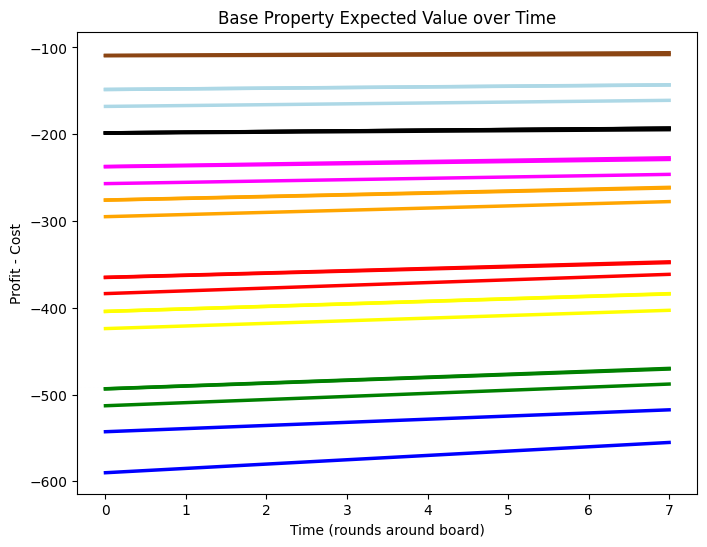

In [95]:
plt.figure(figsize=(8, 6))

for column in one_house_df.columns:
    plt.plot(one_house_df.index, one_house_df[column], label=column, color=color_mapping.get(column, '#000000'), linewidth=2.5)

plt.xlabel('Time (rounds around board)')
plt.ylabel('Profit - Cost')
plt.title('Base Property Expected Value over Time')
# plt.legend(title="Columns")
plt.show()

Here, concentrating on 1-10 area containing the 5 rounds of a normal game, we can see how the railroads have successfully passed The purples and the oranges. This is likely because while the costs of the full set of railroads have not gone up, the costs of the houses are starting to have an impact.

In [96]:
#print order of success at N = 5 which we are using to represent a normal game
check_df = one_house_df.transpose()

check_df[5] = check_df[5].astype(float)
check_df_sorted = check_df.sort_values(by=5, ascending=False)

counter = 0
for val in check_df_sorted.index.values:
    counter += 1
    if counter <= 10:
        print(f"{counter}. {val}")

1. Baltic Avenue
2. Mediterranean Avenue
3. Vermont Avenue
4. Oriental Avenue
5. Connecticut Avenue
6. Reading Railroad
7. B&O Railroad
8. Pennsylvania Railroad
9. Short Line
10. St. Charles Place


### Having 2 Houses

In [118]:
two_house_df = complex_price_df[['location', 'location_type', 'cost_per_house', 'base_cost', '2']].copy() #capture just the part of price we want
two_house_df['probability'] = df_2['Probability_30turns_4players'].copy()


new_columns = {} # do something here
for i in range(1, 1200):
    new_columns[f"{i}"] = (two_house_df['2'] * two_house_df['probability'] * i) + two_house_df['base_cost'] + (2 * two_house_df['cost_per_house'])
new_columns_df = pd.DataFrame(new_columns)

two_house_df = pd.concat([two_house_df, new_columns_df], axis=1)


two_house_df = two_house_df.transpose()
col_names = two_house_df.iloc[0]

two_house_df = two_house_df.drop(two_house_df.index[:6]).reset_index(drop=True)
two_house_df.columns = col_names

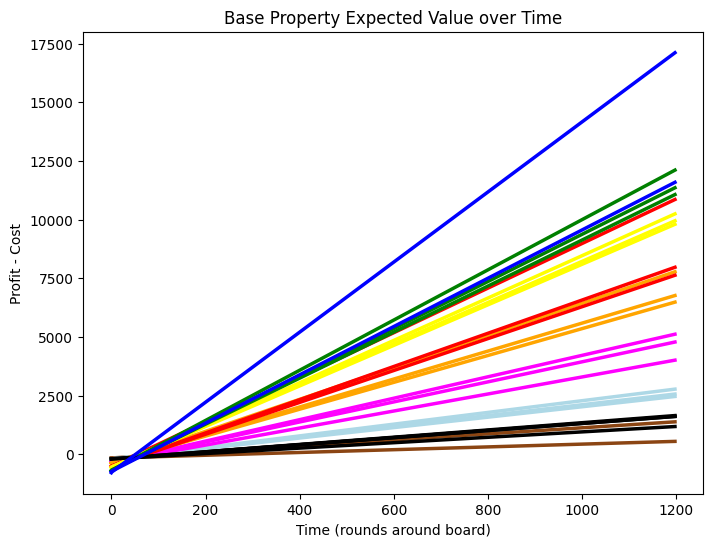

In [122]:
plt.figure(figsize=(8, 6))

for column in two_house_df.columns:
    plt.plot(two_house_df.index, two_house_df[column], label=column, color=color_mapping.get(column, '#000000'), linewidth=2.5)

plt.xlabel('Time (rounds around board)')
plt.ylabel('Profit - Cost')
plt.title('Base Property Expected Value over Time')
# plt.legend(title="Columns")
plt.show()

At this point it's interesting how mixed the different colors are getting towards the extremes, with the colors not lining up nearly as much. At the N=5 level the results are somewhat similar, notably the railroads are continuing to rise!

In [114]:
#print order of success at N = 5 which we are using to represent a normal game
check_df = two_house_df.transpose()

check_df[5] = check_df[5].astype(float)
check_df_sorted = check_df.sort_values(by=5, ascending=False)

counter = 0
for val in check_df_sorted.index.values:
    counter += 1
    if counter <= 10:
        print(f"{counter}. {val}")

1. Baltic Avenue
2. Mediterranean Avenue
3. Vermont Avenue
4. Oriental Avenue
5. Reading Railroad
6. B&O Railroad
7. Pennsylvania Railroad
8. Short Line
9. Connecticut Avenue
10. St. Charles Place


In [121]:
#At the extremes
check_df = two_house_df.transpose()

check_df[1000] = check_df[1000].astype(float)
check_df_sorted = check_df.sort_values(by=1000, ascending=False)

counter = 0
for val in check_df_sorted.index.values:
    counter += 1
    if counter <= 10:
        print(f"{counter}. {val}")

1. Boardwalk
2. Pennsylvania Avenue
3. Park Place
4. Pacific Avenue
5. North Carolina Avenue
6. Illinois Avenue
7. Marvin Gardens
8. Atlantic Avenue
9. Ventnor Avenue
10. Kentucky Avenue


Here at the extreme it's interesting to note that Pennsylvania is able to overtake Park Place and Illinois is able to pass all of the Yellow properties

### Having 3 Houses

In [125]:
three_house_df = complex_price_df[['location', 'location_type', 'cost_per_house', 'base_cost', '3']].copy() #capture just the part of price we want
three_house_df['probability'] = df_2['Probability_30turns_4players'].copy()


new_columns = {} # do something here
for i in range(1, 100):
    new_columns[f"{i}"] = (three_house_df['3'] * three_house_df['probability'] * i) + three_house_df['base_cost'] + (3 * three_house_df['cost_per_house'])
new_columns_df = pd.DataFrame(new_columns)

three_house_df = pd.concat([three_house_df, new_columns_df], axis=1)


three_house_df = three_house_df.transpose()
col_names = three_house_df.iloc[0]

three_house_df = three_house_df.drop(three_house_df.index[:6]).reset_index(drop=True)
three_house_df.columns = col_names


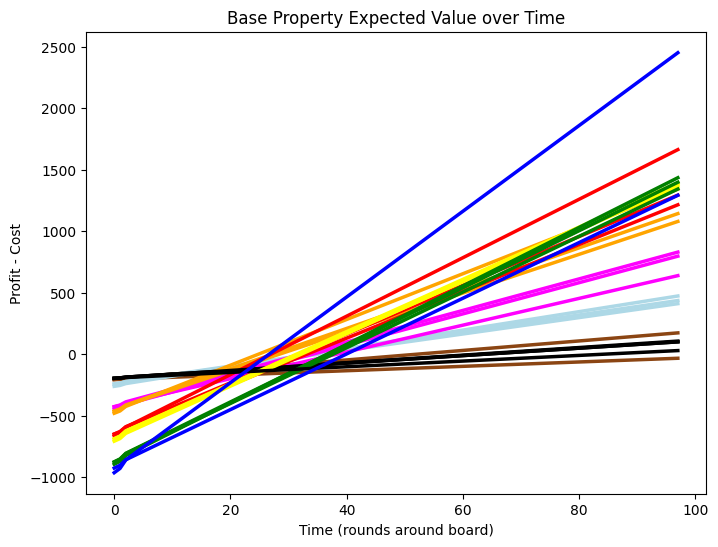

In [126]:
plt.figure(figsize=(8, 6))

for column in three_house_df.columns:
    plt.plot(three_house_df.index, three_house_df[column], label=column, color=color_mapping.get(column, '#000000'), linewidth=2.5)

plt.xlabel('Time (rounds around board)')
plt.ylabel('Profit - Cost')
plt.title('Base Property Expected Value over Time')
# plt.legend(title="Columns")
plt.show()

Here we can see that the graphs become even more erratic, and Boardwalk and Illinois are beginning to become the clear leaders at the extreme

In [129]:
#print order of success at N = 5 which we are using to represent a normal game
check_df = three_house_df.transpose()

check_df[20] = check_df[20].astype(float)
check_df_sorted = check_df.sort_values(by=20, ascending=False)

counter = 0
for val in check_df_sorted.index.values:
    counter += 1
    if counter <= 10:
        print(f"{counter}. {val}")

1. New York Avenue
2. Vermont Avenue
3. Oriental Avenue
4. Connecticut Avenue
5. Tennessee Avenue
6. Baltic Avenue
7. Reading Railroad
8. B&O Railroad
9. Pennsylvania Railroad
10. St. James Place


at N=5, w

### Having 4 Houses

In [132]:
four_house_df = complex_price_df[['location', 'location_type', 'cost_per_house', 'base_cost', '4']].copy() #capture just the part of price we want
four_house_df['probability'] = df_2['Probability_30turns_4players'].copy()

new_columns = {} # do something here
for i in range(1, 100):
    new_columns[f"{i}"] = (four_house_df['4'] * four_house_df['probability'] * i) + four_house_df['base_cost'] + (4 * four_house_df['cost_per_house'])
new_columns_df = pd.DataFrame(new_columns)

four_house_df = pd.concat([four_house_df, new_columns_df], axis=1)


four_house_df = four_house_df.transpose()
col_names = four_house_df.iloc[0]

four_house_df = four_house_df.drop(four_house_df.index[:6]).reset_index(drop=True)
four_house_df.columns = col_names


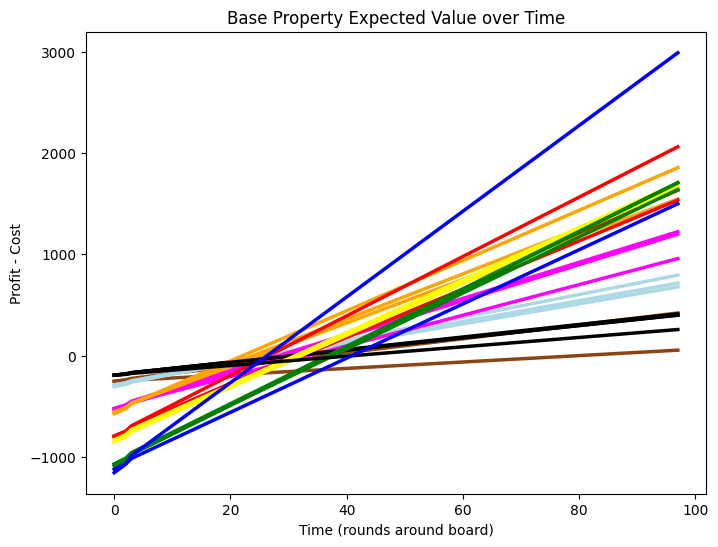

In [133]:
plt.figure(figsize=(8, 6))

for column in four_house_df.columns:
    plt.plot(four_house_df.index, four_house_df[column], label=column, color=color_mapping.get(column, '#000000'), linewidth=2.5)

plt.xlabel('Time (rounds around board)')
plt.ylabel('Profit - Cost')
plt.title('Base Property Expected Value over Time')
# plt.legend(title="Columns")
plt.show()

In [134]:
#print order of success at N = 5 which we are using to represent a normal game
check_df = four_house_df.transpose()

check_df[20] = check_df[20].astype(float)
check_df_sorted = check_df.sort_values(by=20, ascending=False)

counter = 0
for val in check_df_sorted.index.values:
    counter += 1
    if counter <= 10:
        print(f"{counter}. {val}")

1. New York Avenue
2. Reading Railroad
3. B&O Railroad
4. Pennsylvania Railroad
5. Connecticut Avenue
6. Vermont Avenue
7. Oriental Avenue
8. Tennessee Avenue
9. Short Line
10. St. James Place


### Having Hotels

In [136]:
hotel_df = complex_price_df[['location', 'location_type', 'cost_per_house', 'base_cost', '5']].copy() #capture just the part of price we want
hotel_df['probability'] = df_2['Probability_30turns_4players'].copy()

new_columns = {} # do something here
for i in range(1, 100):
    new_columns[f"{i}"] = (hotel_df['5'] * hotel_df['probability'] * i) + hotel_df['base_cost'] + (5 * hotel_df['cost_per_house'])
new_columns_df = pd.DataFrame(new_columns)

hotel_df = pd.concat([hotel_df, new_columns_df], axis=1)


hotel_df = hotel_df.transpose()
col_names = hotel_df.iloc[0]

hotel_df = hotel_df.drop(hotel_df.index[:6]).reset_index(drop=True)
hotel_df.columns = col_names


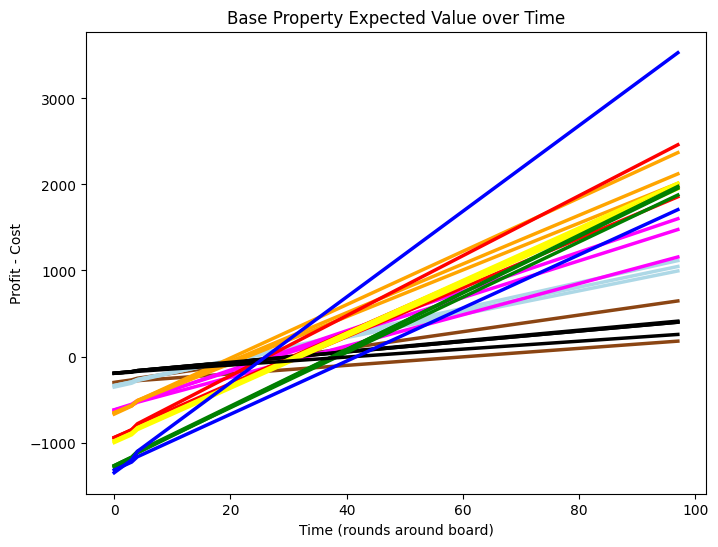

In [137]:
plt.figure(figsize=(8, 6))

for column in hotel_df.columns:
    plt.plot(hotel_df.index, hotel_df[column], label=column, color=color_mapping.get(column, '#000000'), linewidth=2.5)

plt.xlabel('Time (rounds around board)')
plt.ylabel('Profit - Cost')
plt.title('Base Property Expected Value over Time')
# plt.legend(title="Columns")
plt.show()

In [138]:
#print order of success at N = 5 which we are using to represent a normal game
check_df = hotel_df.transpose()

check_df[20] = check_df[20].astype(float)
check_df_sorted = check_df.sort_values(by=20, ascending=False)

counter = 0
for val in check_df_sorted.index.values:
    counter += 1
    if counter <= 10:
        print(f"{counter}. {val}")

1. New York Avenue
2. Vermont Avenue
3. Connecticut Avenue
4. Oriental Avenue
5. Tennessee Avenue
6. Reading Railroad
7. B&O Railroad
8. Pennsylvania Railroad
9. St. James Place
10. Baltic Avenue
